In [1]:
# Install required packages if not already installed
# !pip install kaggle pandas numpy matplotlib seaborn scikit-learn

# Import necessary libraries
import pandas as pd
import zipfile
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional
import os
from sklearn.preprocessing import LabelEncoder

# For model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Download the weather dataset from Kaggle
import kaggle

def download_weather_dataset() -> None:
    """
    Download the weather dataset from Kaggle using the API.
    
    Requires kaggle API credentials to be properly set up.
    """
    try:
        # Download the dataset
        kaggle.api.dataset_download_files(
            'jsphyg/weather-dataset-rattle-package',
            path='./data',
            unzip=False
        )
        print("Dataset downloaded successfully!")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Make sure your Kaggle API credentials are set up correctly.")

# Create data directory if it doesn't exist
os.makedirs('./data', exist_ok=True)

# Download the dataset
download_weather_dataset()


Dataset URL: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
Dataset downloaded successfully!


In [3]:
# Unzip the downloaded dataset

def unzip_dataset() -> None:
    """
    Unzip the downloaded weather dataset.
    """
    zip_path = './data/weather-dataset-rattle-package.zip'
    extract_path = './data/'
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Dataset unzipped successfully!")
        
        # List extracted files
        print("\nExtracted files:")
        for file in os.listdir(extract_path):
            if file.endswith('.csv'):
                print(f"  - {file}")
                
    except FileNotFoundError:
        print(f"Error: {zip_path} not found. Make sure the dataset was downloaded successfully.")
    except Exception as e:
        print(f"Error unzipping dataset: {e}")

# Unzip the dataset
unzip_dataset()


Dataset unzipped successfully!

Extracted files:
  - weatherAUS.csv


In [4]:
# Load the weather dataset
df = pd.read_csv('./data/weatherAUS.csv')

# Display basic information about the dataset
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
df.head()

Dataset loaded successfully!
Shape: (145460, 23)
Columns: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']

First 5 rows:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
# Debug: Check what values are actually in RainToday and RainTomorrow
print("Debugging the binary encoding issue:")
print(f"RainToday unique values: {df['RainToday'].unique()}")
print(f"RainTomorrow unique values: {df['RainTomorrow'].unique()}")
print(f"RainToday data type: {df['RainToday'].dtype}")
print(f"RainTomorrow data type: {df['RainTomorrow'].dtype}")

# Check for any null values
print(f"RainToday null count: {df['RainToday'].isnull().sum()}")
print(f"RainTomorrow null count: {df['RainTomorrow'].isnull().sum()}")

# Sample of actual values
print(f"First 10 RainToday values: {df['RainToday'].head(10).tolist()}")
print(f"First 10 RainTomorrow values: {df['RainTomorrow'].head(10).tolist()}")


Debugging the binary encoding issue:
RainToday unique values: ['No' 'Yes' nan]
RainTomorrow unique values: ['No' 'Yes' nan]
RainToday data type: object
RainTomorrow data type: object
RainToday null count: 3261
RainTomorrow null count: 3267
First 10 RainToday values: ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes']
First 10 RainTomorrow values: ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No']


## Preprocessing Step

1. We will extract month, day_of_year, season, and weekday from the [Date] column
2. Appy One-Hot Encoding to columns [Location, WindGustDir, WindDir9am, WindDir3pm] and Encoding to [RainToday, RainTomorrow]
3. Apply MinMax scaling to [MinTemp, MaxTemp, Temp9am, Temp3pm, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSPeed3pm, Pressure9am, Pressure3pm]
4. Humidity9am, Humidity3pm: Already 0-100%, divide by 100 |AND|
Cloud9am, Cloud3pm: Already 0-8 scale, divide by 8


## 1. Preprocess Data Column

In [6]:
# Extract date features from the Date column
def extract_date_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract useful features from the Date column.
    
    Args:
        df: DataFrame with a 'Date' column
        
    Returns:
        DataFrame with new date features and original Date column removed
    """
    # Make a copy to avoid modifying original
    df_processed = df.copy()
    
    # Convert Date to datetime if it's not already
    df_processed['Date'] = pd.to_datetime(df_processed['Date'])
    
    # Extract month (1-12)
    df_processed['month'] = df_processed['Date'].dt.month
    
    # Extract weekday (0=Monday, 6=Sunday)
    df_processed['weekday'] = df_processed['Date'].dt.dayofweek
    
    # Extract season (0=Spring, 1=Summer, 2=Autumn, 3=Winter)
    def get_season(month: int) -> int:
        if month in [12, 1, 2]:
            return 1  # Summer
        elif month in [3, 4, 5]:
            return 2  # Autumn
        elif month in [6, 7, 8]:
            return 3  # Winter
        else:  # month in [9, 10, 11]
            return 0  # Spring
    
    df_processed['season'] = df_processed['month'].apply(get_season)
    
    # Drop the original Date column
    df_processed = df_processed.drop('Date', axis=1)
    
    print("Date features extracted:")
    print("- month: 1-12")
    print("- weekday: 0=Monday, 6=Sunday")
    print("- season: 0=Spring, 1=Summer, 2=Autumn, 3=Winter (Southern Hemisphere)")
    
    return df_processed

# Apply date feature extraction
df = extract_date_features(df)

# Display the new columns
print(f"\nNew shape: {df.shape}")
print(f"New columns: {list(df.columns[:10])}")  # Show first 10 columns
print("\nSample of extracted date features:")
print(df[['month', 'weekday', 'season']].head())
df.head()


Date features extracted:
- month: 1-12
- weekday: 0=Monday, 6=Sunday
- season: 0=Spring, 1=Summer, 2=Autumn, 3=Winter (Southern Hemisphere)

New shape: (145460, 25)
New columns: ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm']

Sample of extracted date features:
   month  weekday  season
0     12        0       1
1     12        1       1
2     12        2       1
3     12        3       1
4     12        4       1


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,month,weekday,season
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,12,0,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,12,1,1
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,12,2,1
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,No,12,3,1
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,12,4,1


In [7]:
# 2. Cyclical encoding for temporal features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# One-hot encoding for season
season_dummies = pd.get_dummies(df['season'], prefix='season')
df = pd.concat([df, season_dummies], axis=1)

# Drop original temporal columns
df = df.drop(['month', 'weekday', 'season'], axis=1)
df.head()


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Temp9am,Temp3pm,RainToday,RainTomorrow,month_sin,month_cos,season_0,season_1,season_2,season_3
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,16.9,21.8,No,No,-2.449294e-16,1.0,False,True,False,False
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,17.2,24.3,No,No,-2.449294e-16,1.0,False,True,False,False
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,21.0,23.2,No,No,-2.449294e-16,1.0,False,True,False,False
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,18.1,26.5,No,No,-2.449294e-16,1.0,False,True,False,False
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,17.8,29.7,No,No,-2.449294e-16,1.0,False,True,False,False


## 2. One-Hot Encoding Step


In [8]:
# One-hot encoding for categorical columns and binary encoding for Yes/No columns
# One-hot encoding for categorical columns
categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
for col in categorical_cols:
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies], axis=1)

# Binary encoding for Yes/No columns
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Drop original categorical columns
df = df.drop(categorical_cols, axis=1)

print(f"Shape after one-hot encoding: {df.shape}")
print(f"Sample of encoded columns:")
print(df[['RainToday', 'RainTomorrow']].head())

Shape after one-hot encoding: (145460, 121)
Sample of encoded columns:
   RainToday  RainTomorrow
0        0.0           0.0
1        0.0           0.0
2        0.0           0.0
3        0.0           0.0
4        0.0           0.0


## 3. MinMax Scaling Step


In [9]:
# MinMax scaling for numerical columns
minmax_cols = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Rainfall', 
               'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 
               'WindSpeed3pm', 'Pressure9am', 'Pressure3pm']

scaler = MinMaxScaler()
df[minmax_cols] = scaler.fit_transform(df[minmax_cols])

print(f"MinMax scaling applied to {len(minmax_cols)} columns")
print(f"Sample of scaled columns:")
print(df[minmax_cols[:4]].head())

MinMax scaling applied to 12 columns
Sample of scaled columns:
    MinTemp   MaxTemp   Temp9am   Temp3pm
0  0.516509  0.523629  0.508439  0.522073
1  0.375000  0.565217  0.514768  0.570058
2  0.504717  0.576560  0.594937  0.548944
3  0.417453  0.620038  0.533755  0.612284
4  0.613208  0.701323  0.527426  0.673704


## 4. Simple Division Scaling Step


In [ ]:
# Humidity columns: 0-100% → divide by 100
humidity_cols = ['Humidity9am', 'Humidity3pm']
df[humidity_cols] = df[humidity_cols] / 100

# Cloud columns: 0-8 scale → divide by 8
cloud_cols = ['Cloud9am', 'Cloud3pm']
df[cloud_cols] = df[cloud_cols] / 8

print(f"Humidity range: {df[humidity_cols].min().min():.2f} - {df[humidity_cols].max().max():.2f}")
print(f"Cloud range: {df[cloud_cols].min().min():.2f} - {df[cloud_cols].max().max():.2f}")
print(f"\nFinal shape: {df.shape}")

Humidity range: 0.00 - 1.00
Cloud range: 0.00 - 1.12

Final shape: (145460, 121)


# Section 2: Classification Model Building

Now we'll build a neural network model optimized for our weather classification task. Our dataset has:
- **121 features** after preprocessing
- **Binary classification** task (RainTomorrow: Yes/No)
- **Mixed feature types**: numerical (scaled) + one-hot encoded categorical


In [11]:
# Check the impact of missing target values
print("=== Analysis of Missing Target Values ===")
print(f"Original dataset shape: {df.shape}")
print(f"Missing values in RainTomorrow: {df['RainTomorrow'].isnull().sum()}")
print(f"Percentage of missing target values: {df['RainTomorrow'].isnull().sum() / len(df) * 100:.2f}%")

# Explain why we drop missing targets
print("\n=== Why We Drop Missing Target Values ===")
print("In supervised learning, we MUST drop rows with missing target values because:")
print("1. Model cannot learn from samples without known outcomes")
print("2. Cannot calculate loss/error for samples without target values")
print("3. Cannot evaluate model performance on unknown targets")
print("\nThis is different from missing features, which we can impute with median/mean/mode.")


=== Analysis of Missing Target Values ===
Original dataset shape: (145460, 121)
Missing values in RainTomorrow: 3267
Percentage of missing target values: 2.25%

=== Why We Drop Missing Target Values ===
In supervised learning, we MUST drop rows with missing target values because:
1. Model cannot learn from samples without known outcomes
2. Cannot calculate loss/error for samples without target values
3. Cannot evaluate model performance on unknown targets

This is different from missing features, which we can impute with median/mean/mode.


In [12]:
# Prepare data for training - COMPREHENSIVE MISSING VALUE HANDLING
print("=== Before Missing Value Handling ===")
print(f"Dataset shape: {df.shape}")
print(f"Total missing values: {df.isnull().sum().sum()}")
print(f"Missing values by column:")
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0].sort_values(ascending=False))

# Handle missing values systematically
# 1. First handle numerical columns
numerical_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
                  'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Pressure9am', 
                  'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
                  'Humidity9am', 'Humidity3pm', 'month_sin', 'month_cos']

for col in numerical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# 2. Handle boolean columns (one-hot encoded) - fill with False (most common)
boolean_cols = [col for col in df.columns if col.startswith(('Location_', 'WindGustDir_', 'WindDir9am_', 'WindDir3pm_', 'season_'))]
for col in boolean_cols:
    df[col] = df[col].fillna(False)

# 3. Handle binary target columns
df['RainToday'] = df['RainToday'].fillna(0)  # Assume no rain if missing

# 4. Drop rows with missing target variable (required for supervised learning)
print(f"\n=== Target Variable Analysis ===")
print(f"Missing values in RainTomorrow before cleaning: {df['RainTomorrow'].isnull().sum()}")
df_clean = df.dropna(subset=['RainTomorrow'])

print(f"\n=== After Comprehensive Cleaning ===")
print(f"Dataset shape: {df_clean.shape}")
print(f"Missing values remaining: {df_clean.isnull().sum().sum()}")

# Final check - if any missing values remain, fill them
if df_clean.isnull().sum().sum() > 0:
    print("Remaining missing values:")
    remaining_missing = df_clean.isnull().sum()
    print(remaining_missing[remaining_missing > 0])
    # Fill any remaining missing values with appropriate defaults
    df_clean = df_clean.fillna(0)
    print(f"After final fillna(0): {df_clean.isnull().sum().sum()} missing values")

# Separate features and target
X = df_clean.drop('RainTomorrow', axis=1)
y = df_clean['RainTomorrow']

print(f"\n=== Final Dataset ===")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features missing values: {X.isnull().sum().sum()}")
print(f"Target missing values: {y.isnull().sum()}")
print(f"Target distribution:")
print(y.value_counts(normalize=True))


=== Before Missing Value Handling ===
Dataset shape: (145460, 121)
Total missing values: 318128
Missing values by column:
Sunshine         69835
Evaporation      62790
Cloud3pm         59358
Cloud9am         55888
Pressure9am      15065
Pressure3pm      15028
WindGustSpeed    10263
Humidity3pm       4507
Temp3pm           3609
RainTomorrow      3267
Rainfall          3261
RainToday         3261
WindSpeed3pm      3062
Humidity9am       2654
WindSpeed9am      1767
Temp9am           1767
MinTemp           1485
MaxTemp           1261
dtype: int64

=== Target Variable Analysis ===
Missing values in RainTomorrow before cleaning: 3267

=== After Comprehensive Cleaning ===
Dataset shape: (142193, 121)
Missing values remaining: 0

=== Final Dataset ===
Features shape: (142193, 120)
Target shape: (142193,)
Features missing values: 0
Target missing values: 0
Target distribution:
RainTomorrow
0.0    0.775819
1.0    0.224181
Name: proportion, dtype: float64


In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train target distribution: {y_train.value_counts(normalize=True).round(3).to_dict()}")
print(f"Test target distribution: {y_test.value_counts(normalize=True).round(3).to_dict()}")

Training set: (113754, 120)
Test set: (28439, 120)
Train target distribution: {0.0: 0.776, 1.0: 0.224}
Test target distribution: {0.0: 0.776, 1.0: 0.224}


In [14]:
def create_weather_classifier(input_dim: int) -> keras.Model:
    """
    Create a deep neural network optimized for weather classification.
    
    Architecture designed for tabular data with mixed feature types:
    - Dense layers with batch normalization
    - Dropout for regularization
    - ReLU activation for hidden layers
    - Sigmoid output for binary classification
    """
    model = keras.Sequential([
        # Input layer with smaller size for stability
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.1),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Create the model
model = create_weather_classifier(X_train.shape[1])

# Compile with appropriate loss and metrics for binary classification
# Use lower learning rate for stability
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        15,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,265 (106.50 KB)

 Trainable params: 26,817 (104.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
# Set up callbacks for training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model
print("Starting model training...")
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Starting model training...
Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5935 - loss: 0.6688 - precision: 0.2704 - recall: 0.4821 - val_accuracy: 0.7385 - val_loss: 0.6484 - val_precision: 0.4273 - val_recall: 0.4840 - learning_rate: 1.0000e-04
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7381 - loss: 0.5561 - precision: 0.4098 - recall: 0.3893 - val_accuracy: 0.8043 - val_loss: 0.5140 - val_precision: 0.6153 - val_recall: 0.3431 - learning_rate: 1.0000e-04
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - loss: 0.4899 - precision: 0.5269 - recall: 0.3705 - val_accuracy: 0.8181 - val_loss: 0.4349 - val_precision: 0.6369 - val_recall: 0.4418 - learning_rate: 1.0000e-04
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7995 - loss: 0.4516 - precision: 0.5743 - recall: 0.3974 - val_accuracy: 0.8244 - val_loss: 0.4039 - val_precision: 0.6392 - val_recall: 0.5011 - learning_rate: 1.0000e-04
Epoch 5/100
178/1

In [16]:
# Evaluate model performance
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

print("=== Model Performance ===")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Calculate F1-Score safely (handle division by zero)
if test_precision + test_recall > 0:
    f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    print(f"Test F1-Score: {f1_score:.4f}")
else:
    print("Test F1-Score: Cannot calculate (precision + recall = 0)")

# Generate predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain'], zero_division=0))

=== Model Performance ===
Test Accuracy: 0.8568
Test Precision: 0.7364
Test Recall: 0.5624
Test F1-Score: 0.6377

=== Classification Report ===
              precision    recall  f1-score   support

     No Rain       0.88      0.94      0.91     22064
        Rain       0.74      0.56      0.64      6375

    accuracy                           0.86     28439
   macro avg       0.81      0.75      0.77     28439
weighted avg       0.85      0.86      0.85     28439



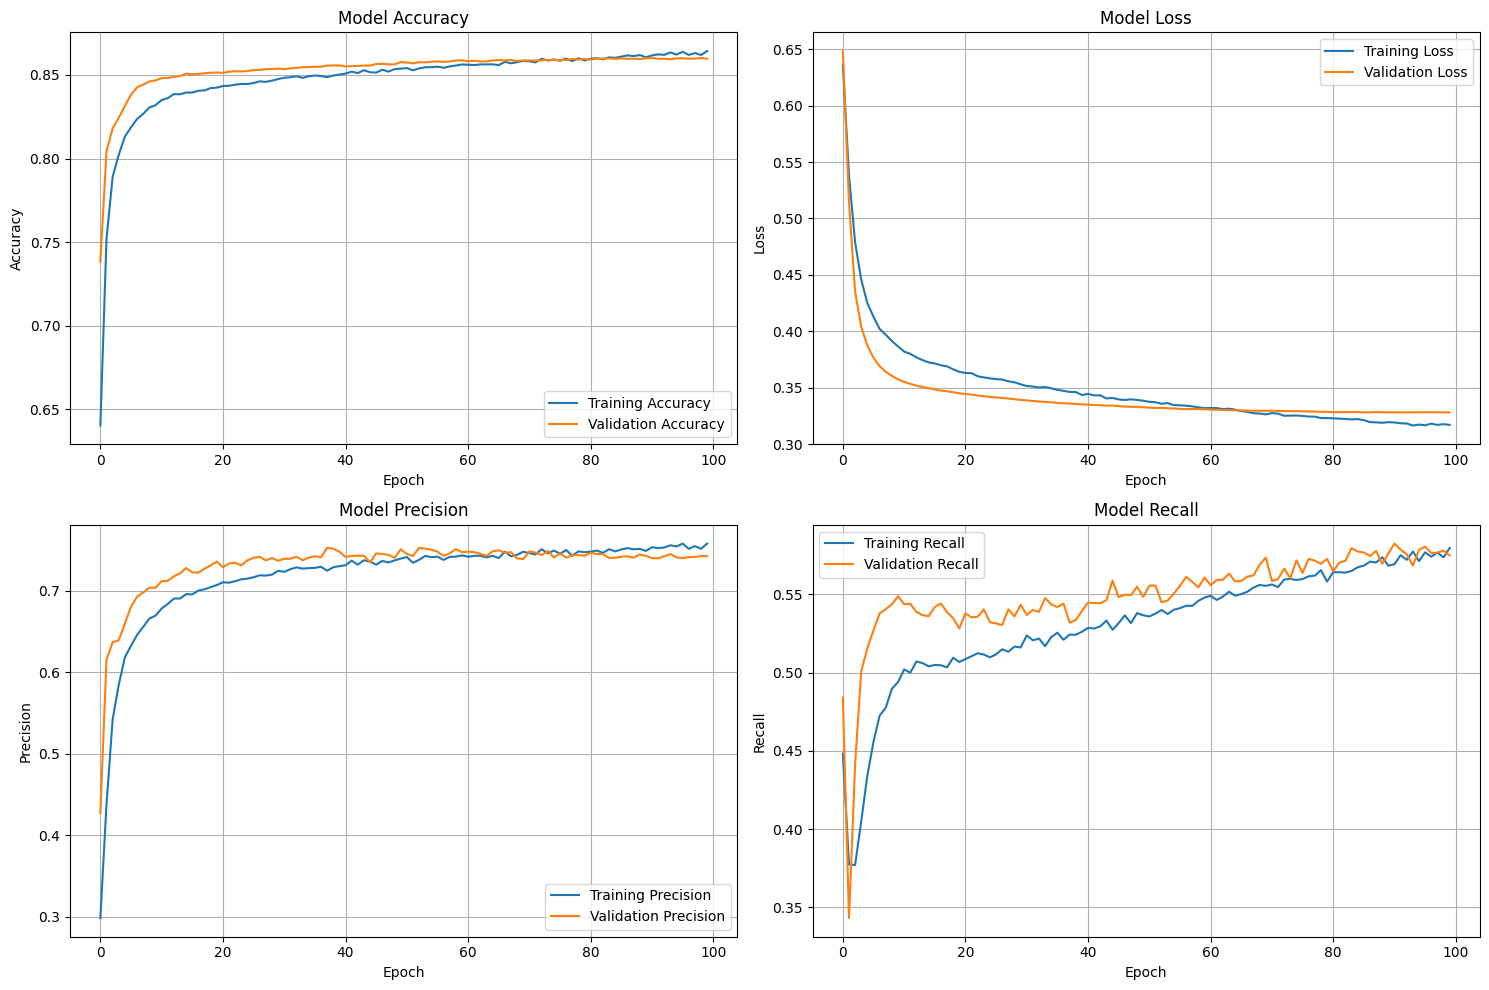

In [17]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
